In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision.models as models
from torchvision.models.resnet import ResNet, BasicBlock

In [2]:
# 自定义数据集类
class FERPlusDataset(Dataset):
    def __init__(self, csv_file, usage='Training', transform=None):
        self.data = pd.read_csv(csv_file)
        self.data.columns = self.data.columns.str.strip()  # 清除列名空格
        self.data = self.data[self.data['Usage'] == usage]

        # 排除 unknown 和 NF 分布不为 0 的行（可选）
        self.data = self.data[(self.data['NF'] == 0) & (self.data['unknown'] <= 1)]

        self.label_keys = ['neutral', 'happiness', 'surprise', 'sadness',
                           'anger', 'disgust', 'fear', 'contempt', 'unknown']   #9种class
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image = np.fromstring(row['pixels'], dtype=int, sep=' ').astype(np.uint8).reshape(48, 48)
        image = image.astype(np.float32) / 255.0
        image = torch.tensor(image).unsqueeze(0)


        label = row[self.label_keys].values.astype(np.float32)
        label = label / label.sum()  # soft label 归一化
        label = torch.tensor(label)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
class channel_attention(nn.Module):
    def __init__(self, in_channel, reduce=8):
        super(channel_attention, self).__init__()
        # max/avg pooling
        self.max_pooling = nn.AdaptiveMaxPool2d(1)
        self.avg_pooling = nn.AdaptiveAvgPool2d(1)

        self.max_lin1 = nn.Linear(in_channel, in_channel // reduce, bias=False)
        self.max_lin2 = nn.Linear(in_channel // reduce, in_channel, bias=False)
        self.avg_lin1 = nn.Linear(in_channel, in_channel // reduce, bias=False)
        self.avg_lin2 = nn.Linear(in_channel // reduce, in_channel, bias=False)

        self.dropout = nn.Dropout(p=0.2)

        # activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # get x size
        b, c, _, _ = x.size()
        
        # max pooling process
        max_output = self.max_pooling(x).view(b, c)
        max_output = self.max_lin1(max_output)
        max_output = self.relu(max_output)
        max_output = self.dropout(max_output)
        max_output = self.max_lin2(max_output)
        

        # avg pooling process
        avg_output = self.avg_pooling(x).view(b, c)
        avg_output = self.avg_lin1(avg_output)
        avg_output = self.relu(avg_output)
        avg_output = self.dropout(avg_output)
        avg_output = self.avg_lin2(avg_output)

        # add attention
        output = max_output + avg_output

        # activate
        output = self.sigmoid(output)
        
        output = output.view(b, c, 1, 1)

        return output

class spatial_attention(nn.Module):
    def __init__(self, kernel_size=3):
        super(spatial_attention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        max_output, _ = torch.max(x, dim=1, keepdim=True)
        avg_output = torch.mean(x, dim=1, keepdim=True)

        # add avg and max result
        output = torch.cat([max_output, avg_output], dim=1)

        output = self.conv(output)

        output = self.sigmoid(output)

        return output

class CBAM(nn.Module):
    def __init__(self, in_channel, reduce=8, kernel_size=3):
        super(CBAM, self).__init__()
        self.channel_attention = channel_attention(in_channel, reduce)
        self.spatial_attention = spatial_attention(kernel_size)

    def forward(self, x):
        out = self.channel_attention(x) * x + x
        out = self.spatial_attention(out) * out + out
        return out

class residual_block_CBAM(BasicBlock):
    def __init__(self, *args, **kwargs):
        super(residual_block_CBAM, self).__init__(*args, **kwargs)
        self.cbam = CBAM(self.conv2.out_channels)

    def forward(self, x):
        output = self.conv1(x)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)

        # add CBAM block
        output = self.cbam(output)

        # residual connection
        residual = x
        if self.downsample is not None:
            residual = self.downsample(x)
        output += residual
        
        output = self.relu(output)

        return output

class ResNet_CBAM(nn.Module):
    def __init__(self, classes_num=9):
        super(ResNet_CBAM, self).__init__()
        
        self.model = ResNet(block=residual_block_CBAM, layers=[2, 2, 2, 2])

        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        self.model.fc = nn.Linear(self.model.fc.in_features, classes_num)
    
    def forward(self, x):
        x = self.model(x)
        return x

In [5]:
# 混淆矩阵可视化
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

In [6]:
# 评估模型
def evaluate_model(model, data_loader, device, name="Validation"):
    model.eval()
    kl_loss_fn = nn.KLDivLoss(reduction='batchmean')
    mse_loss_fn = nn.MSELoss(reduction='mean')

    total_kl = 0.0
    total_expected_acc = 0.0
    total_mse = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            log_probs = torch.log_softmax(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)

            # KL散度
            kl = kl_loss_fn(log_probs, labels)

            # 归一化的Expected Accuracy（分布点积平均值）
            numerator = torch.sum(probs * labels, dim=1)
            denominator = torch.sum(labels * labels, dim=1) + 1e-10  # 避免除零
            expected_acc = (numerator / denominator).mean()

            # 均方误差
            mse = mse_loss_fn(probs, labels)

            batch_size = images.size(0)
            total_kl += kl.item() * batch_size
            total_expected_acc += expected_acc.item() * batch_size
            total_mse += mse.item() * batch_size
            num_samples += batch_size

    avg_kl = total_kl / num_samples
    avg_expected_acc = total_expected_acc / num_samples
    avg_mse = total_mse / num_samples

    print(f"\n{name} Evaluation Metrics:")
    print(f"  KL Divergence:      {avg_kl:.4f}")
    print(f"  Expected Accuracy:  {avg_expected_acc:.4f}")
    print(f"  Mean Squared Error: {avg_mse:.4f}\n")

    return avg_kl, avg_expected_acc, avg_mse

In [7]:
def plot_training_curves(train_losses,
                         train_kls, val_kls,
                         train_expected_accuracies, val_expected_accuracies,
                         train_mses, val_mses):
    epochs = list(range(1, len(train_losses)+1))

    # 1. Train KL Loss vs Val KL Loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_kls, label='Train KL', color='blue')
    plt.plot(epochs, val_kls, label='Val KL', color='orange')
    plt.xlabel("Epoch")
    plt.ylabel("KL Divergence")
    plt.title("KL Divergence (Train vs Val)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. Expected Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_expected_accuracies, label='Train Expected Accuracy', color='blue')
    plt.plot(epochs, val_expected_accuracies, label='Val Expected Accuracy', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Expected Accuracy")
    plt.title("Expected Accuracy (Train vs Val)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. MSE
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_mses, label='Train MSE', color='blue')
    plt.plot(epochs, val_mses, label='Val MSE', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.title("MSE (Train vs Val)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 4. Raw training KL loss (if different from train_kl)
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label='Raw Training KL Loss (from optimizer)', color='purple')
    plt.xlabel("Epoch")
    plt.ylabel("KL Loss")
    plt.title("Training KL Loss (from backprop)")
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
def plot_test_curve(test_kl, test_acc, test_mse):
    metrics = ['KL Divergence', 'Expected Accuracy', 'MSE']
    values = [test_kl, test_acc, test_mse]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics, values)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')

    plt.title("Test Set Evaluation Metrics")
    plt.ylim(0, max(values)*1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

Epoch [1/10] Avg Training KL Loss: 0.8814

Train Evaluation Metrics:
  KL Divergence:      0.7094
  Expected Accuracy:  0.6644
  Mean Squared Error: 0.0271


Validation Evaluation Metrics:
  KL Divergence:      0.7908
  Expected Accuracy:  0.6255
  Mean Squared Error: 0.0313

Epoch [2/10] Avg Training KL Loss: 0.6413

Train Evaluation Metrics:
  KL Divergence:      0.5493
  Expected Accuracy:  0.7441
  Mean Squared Error: 0.0196


Validation Evaluation Metrics:
  KL Divergence:      0.6371
  Expected Accuracy:  0.6981
  Mean Squared Error: 0.0243

Epoch [3/10] Avg Training KL Loss: 0.5416

Train Evaluation Metrics:
  KL Divergence:      0.5588
  Expected Accuracy:  0.7069
  Mean Squared Error: 0.0207


Validation Evaluation Metrics:
  KL Divergence:      0.6941
  Expected Accuracy:  0.6451
  Mean Squared Error: 0.0278

Epoch [4/10] Avg Training KL Loss: 0.4759

Train Evaluation Metrics:
  KL Divergence:      0.4175
  Expected Accuracy:  0.7837
  Mean Squared Error: 0.0135


Validation 

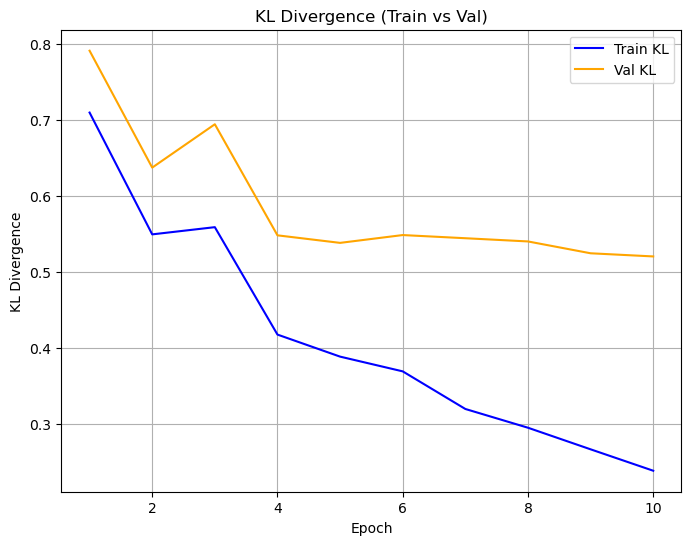

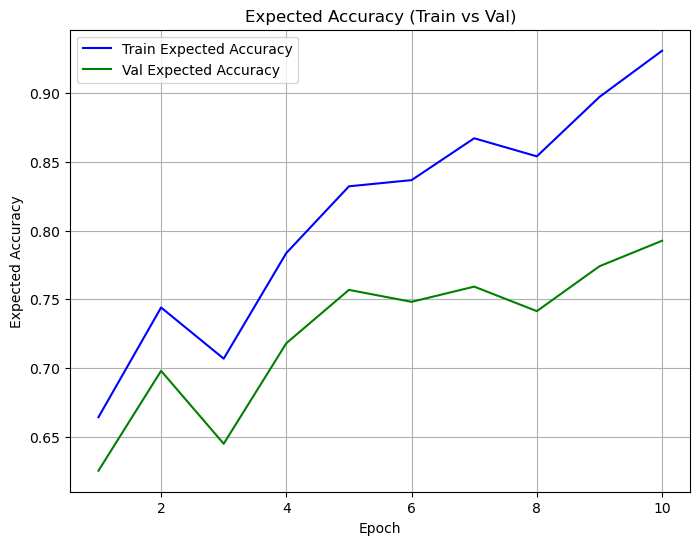

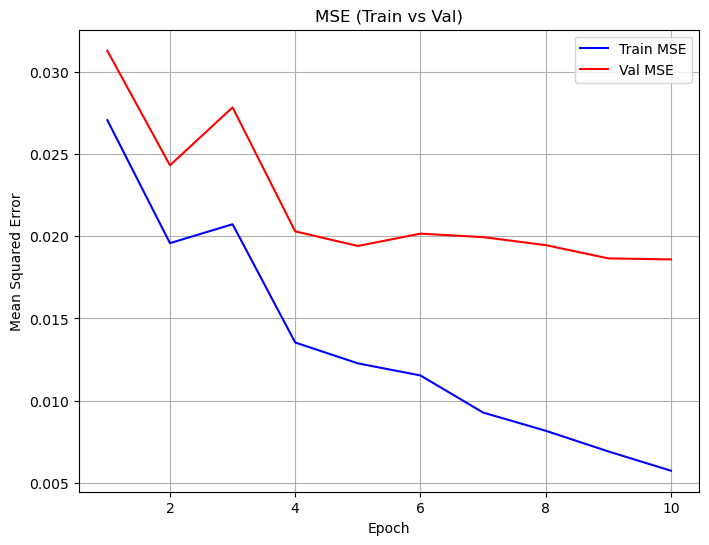

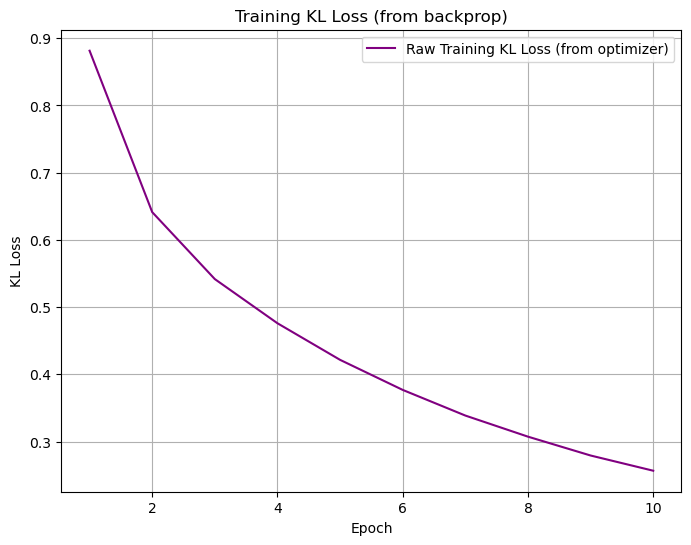

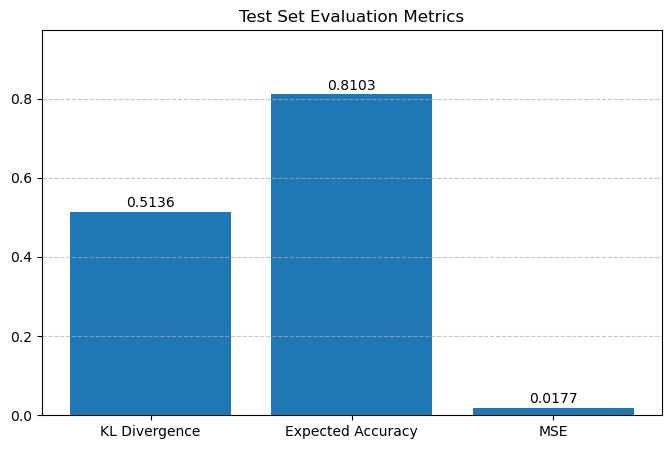

In [9]:
# 主函数
def main():
    fer_path = 'fer2013_softlabel.csv'  # 包含soft labels的csv
    train_dataset = FERPlusDataset(fer_path, usage='Training')
    val_dataset = FERPlusDataset(fer_path, usage='PublicTest')
    test_dataset = FERPlusDataset(fer_path, usage='PrivateTest')

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = ResNet_CBAM().to(device)

    criterion = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.LogSoftmax(dim=1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    #预设存储的变量，用于画图
    train_losses = []
    train_kls = []
    val_kls = []
    train_expected_accuracies = []
    val_expected_accuracies = []
    train_mses = []
    val_mses = []

    #设定epoch
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(softmax(outputs), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)

        # 用每轮平均loss表示loss，输出平均loss
        print(f"Epoch [{epoch + 1}/{num_epochs}] Avg Training KL Loss: {avg_loss:.4f}")

        #获得kl, expect acc, mse, 输出结果
        train_kl, train_acc, train_mse = evaluate_model(model, train_loader, device, name="Train")
        val_kl, val_acc, val_mse = evaluate_model(model, val_loader, device, name="Validation")


        #train_loss for training
        train_losses.append(avg_loss)

        #kl for train and val
        train_kls.append(train_kl)
        val_kls.append(val_kl)

        #expected_accuracy for train and val
        train_expected_accuracies.append(train_acc)
        val_expected_accuracies.append(val_acc)

        #mse for train and val
        train_mses.append(train_mse)
        val_mses.append(val_mse)

        #print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss:.4f}")

        # 重复输出了validation，可以删掉
        # # 每轮都在验证集上评估
        # evaluate_model(model, val_loader, device, name="Validation")

    # 训练完成后在测试集评估
    test_kl, test_acc, test_mse = evaluate_model(model, test_loader, device, name="Test")

    #绘制train,validation,test的图
    plot_training_curves(train_losses, train_kls, val_kls,
                         train_expected_accuracies, val_expected_accuracies,
                         train_mses, val_mses)
    plot_test_curve(test_kl, test_acc, test_mse)

if __name__ == "__main__":
    main()